# tensorFlow物件偵測的 Demo

# Imports

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
print('成功import12')

成功import12


## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
print('env ok')

env ok


## Object detection imports
Here are the imports from the object detection module.

In [4]:
from utils import label_map_util
# 內含有將物件偵測結果視覺化的API
from utils import visualization_utils as vis_util
print('ok')

ok


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
# TF已經訓練好的模型名稱
# 應該是最快的Model
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'

# 中等速度的Model
# 第一張圖處理14.156，後面的圖處理每張大約花4~5秒的時間。
# MODEL_NAME = 'rfcn_resnet101_coco_11_06_2017'

# # 賭賭看改用這個比較慢的模型，可以跑但是很慢，這是最慢的模型一張圖要花40多秒，最猛的模型
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'

# TF已經訓練好的模型檔案(本身是一個tar.gz的壓縮檔)
MODEL_FILE = MODEL_NAME + '.tar.gz'

# 這個TF訓練好模型 所在網站的目錄名稱
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# TF實際用來做物件偵測的模型 
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# 這個模型對應到的種類txt檔，內涵每個種類的索引&名稱
# 之後物件偵測得到的資訊會是索引，所以需要此文件參考名稱
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# 預設模型種類數量 為90種
NUM_CLASSES = 90
print('Model preparation is ok...')

Model preparation is ok...


## Download Model (如果之前下載過模組，那該這個區塊可以不用再執行一次)

In [6]:
# opener = urllib.request.URLopener()
# # opener.retrieve(下載的檔案來源, 下載的檔案存放的本地位址)
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#     file_name = os.path.basename(file.name)
#     if 'frozen_inference_graph.pb' in file_name:
#         tar_file.extract(file, os.getcwd())
# print('Download Model is ok', os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names,

so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  

Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = (label_map_util.convert_label_map_to_categories(
    label_map, 
    max_num_classes=NUM_CLASSES, 
    use_display_name=True))

category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'name': 'person', 'id': 1}, 2: {'name': 'bicycle', 'id': 2}, 3: {'name': 'car', 'id': 3}, 4: {'name': 'motorcycle', 'id': 4}, 5: {'name': 'airplane', 'id': 5}, 6: {'name': 'bus', 'id': 6}, 7: {'name': 'train', 'id': 7}, 8: {'name': 'truck', 'id': 8}, 9: {'name': 'boat', 'id': 9}, 10: {'name': 'traffic light', 'id': 10}, 11: {'name': 'fire hydrant', 'id': 11}, 13: {'name': 'stop sign', 'id': 13}, 14: {'name': 'parking meter', 'id': 14}, 15: {'name': 'bench', 'id': 15}, 16: {'name': 'bird', 'id': 16}, 17: {'name': 'cat', 'id': 17}, 18: {'name': 'dog', 'id': 18}, 19: {'name': 'horse', 'id': 19}, 20: {'name': 'sheep', 'id': 20}, 21: {'name': 'cow', 'id': 21}, 22: {'name': 'elephant', 'id': 22}, 23: {'name': 'bear', 'id': 23}, 24: {'name': 'zebra', 'id': 24}, 25: {'name': 'giraffe', 'id': 25}, 27: {'name': 'backpack', 'id': 27}, 28: {'name': 'umbrella', 'id': 28}, 31: {'name': 'handbag', 'id': 31}, 32: {'name': 'tie', 'id': 32}, 33: {'name': 'suitcase', 'id': 33}, 34: {'name': 'frisbee

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [148]:
import time 
IMAGE_HEAD_NAME = 'person{}.jpg'
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, IMAGE_HEAD_NAME.format(i)) for i in range(0, 10) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [149]:
#除了看已看出有哪些物種，也能看出對應後images_obj_coordinates和image_obj_scores的索引
images_obj_classes_indexs = []

# 有什麼種類的物件
images_obj_classes = []
images_obj_coordinates = []
images_obj_scores = []

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      tStart = time.time()
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.

      image_np = load_image_into_numpy_array(image)
        

      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
#     # 印出每個物件的位置.分數.種類
#       print('boxes[0]:', boxes[0])
#       print('scores[0]:', scores[0])
#       print('classes:', classes)
#       print('\n\n\n')
#       for i in range(2):
#           print("-----------------------------------------------------")
#       print('---------------- %s--------------' % image_path)      
#       for i in range(2):
#         print("-----------------------------------------------------")
      # 分數高於0.5的才可以視為相符
      obj_length = len([x for x in scores[0] if x > 0.6])
      width, height = image.size
    
      # 第一實驗魔改_Begin 該圖片所有的物件種類   
      all_objs = classes[0]
      ok_objs = all_objs[0:obj_length]
      objs_classes = set(ok_objs)
    
      # Result 1 對應原始物件索引陣列的字典(Key為類別名， Value為對應原始陣列的物件索引陣列)
      img_classes = dict()
      
      # newnew＠＠＠＠
      img_obj_class_indexs = dict()
    
      for obj_class in objs_classes:
        img_classes[category_index[obj_class]['name']] = len(np.nonzero(ok_objs == obj_class)[0])
        
        img_obj_class_indexs[category_index[obj_class]['name']] = np.nonzero(ok_objs == obj_class)[0]
        print('obj_class ', category_index[obj_class]['name'], ":", np.nonzero(ok_objs == obj_class)[0])
#         print(category_index[obj_class]['name'], ':', len(np.nonzero(ok_objs == obj_class)[0]))
#         print('種類:', category_index[obj_class]['name'])
#         print(np.nonzero(ok_objs == obj_class)[0], '有', len(np.nonzero(ok_objs == obj_class)[0]),'個') 
        
      # Result 2 原始物件的標記位置陣列[(x1, y1, x2, y2)]
      img_obj_coordinates = boxes[0][0:obj_length]
        
      # Result 3 原始物件的相似分數陣列
      img_obj_scores = scores[0][0:obj_length]

      # 標示每個圖片上所有的物件Visualization of the results of a detection.  
#     # 如果要顯示圖片在ipynb，這個區塊可以取消註解 
#       vis_util.visualize_boxes_and_labels_on_image_array(
#           image_np,
#           np.squeeze(boxes),
#           np.squeeze(classes).astype(np.int32),
#           np.squeeze(scores),
#           category_index,
#           use_normalized_coordinates=True,
#           line_thickness=4)
#       plt.figure(figsize=IMAGE_SIZE)
#       plt.imshow(image_np)
#       # 如果要顯示圖片在ipynb，這個區塊可以取消註解 
      # 第一實驗魔改_End
      images_obj_classes_indexs.append(img_obj_class_indexs)
      images_obj_classes.append(img_classes)
      images_obj_coordinates.append(img_obj_coordinates)
      images_obj_scores.append(img_obj_scores)
        
      tEnd = time.time()
      print('每個圖片建立檔案結束:', tEnd - tStart)
print('結束')


obj_class  person : [0]
每個圖片建立檔案結束: 6.489147901535034
obj_class  person : [0]
每個圖片建立檔案結束: 3.209169864654541
obj_class  person : [0]
每個圖片建立檔案結束: 2.7755980491638184
obj_class  person : [0]
每個圖片建立檔案結束: 0.6198861598968506
obj_class  person : [0]
每個圖片建立檔案結束: 2.815216064453125
obj_class  person : [0]
每個圖片建立檔案結束: 0.1943528652191162
obj_class  tie : [0]
obj_class  person : [1]
每個圖片建立檔案結束: 0.1787090301513672
obj_class  person : [0]
每個圖片建立檔案結束: 0.3925819396972656
obj_class  person : [0 1]
每個圖片建立檔案結束: 0.23527884483337402
obj_class  person : [0]
每個圖片建立檔案結束: 2.734863042831421
結束


b圖跟 以下索引的A組圖 配對成功:
[0, 1, 2, 3, 4, 5]


 B組....
------ 秀出B圖的物件字典 ------
{'person': 1}
------ 秀出B圖的 物件相似分數陣列 ------
b_obj_scores[0] = 0.9813705086708069
------ 秀出B圖的 物件座標陣列 ------
a_obj_coordinates[0] = [ 0.09942508  0.05048242  0.99388659  0.71761   ]

第二實驗_比對結束: 0.0033409595489501953
b_image讀取name
width: 1332
height 1776
132 89 1323 1274
-=====================================
-=====================================
-=====================================
-=====================================
a_obj_coordinates[0]
物件：  646 6 1327 1457
a_obj_coordinates[1]
物件：  355 4 1285 1767
a_obj_coordinates[2]
物件：  684 10 1326 1538
a_obj_coordinates[3]
物件：  1 265 1329 1762
a_obj_coordinates[4]
物件：  684 10 1326 1538
a_obj_coordinates[5]
物件：  70 24 1332 1757
該區塊花費時間: 0.32544994354248047


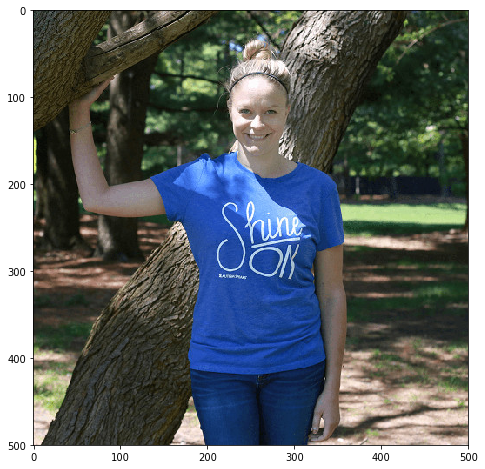

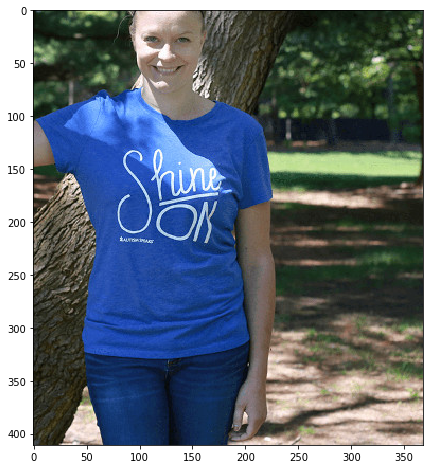

In [151]:
import cv2


# 實驗4
# 此為一對多的實驗
# 讀取一個圖片，從20張圖片挑出符合物件條件&色彩特徵相似的的圖片。
tStart = time.time()

# 取樣A組的圖片數，ex: A_SIZE = 76，代表A組的突圍dog0.jpg~dog75.jpg， B組圖則是dog76.jpg
A_SIZE = 7

# A組圖代表 前A_SIZE個 物件陣列索引a陣列, 圖片的物件字典, 相似分數, 物件座標
a_obj_indexs = images_obj_classes_indexs[0:A_SIZE]
a_obj_data = images_obj_classes[0:A_SIZE]
a_obj_scores = images_obj_scores[0:A_SIZE]
a_obj_coordinates = images_obj_coordinates[0:A_SIZE]

# B組圖代表 第A_SIZE個 物件陣列索引a陣列, 圖片的物件字典, 相似分數, 物件座標
b_obj_indexs = images_obj_classes_indexs[A_SIZE]
b_obj_data = images_obj_classes[A_SIZE]
b_obj_scores = images_obj_scores[A_SIZE]
b_obj_coordinates = images_obj_coordinates[A_SIZE]

# b_match_a，為圖片B 跟 A組圖片們物件數比對成功串列的串列。
b_match_a = list()
b_objs = b_obj_data
for a_key, a_objs in enumerate(a_obj_data):
    if b_objs == a_objs:
        b_match_a.append(a_key)
print('b圖跟 以下索引的A組圖 配對成功:')
print(b_match_a)

    

print('\n\n B組....')
print('------ 秀出B圖的物件字典 ------')
print(b_obj_data)    
# 秀出B圖的 物件相似分數陣列
print('------ 秀出B圖的 物件相似分數陣列 ------')
for b_key, b_scores in enumerate(b_obj_scores):
    print('b_obj_scores[{}] = {}'.format(b_key, b_scores))
# 秀出B圖的 物件座標陣列
print('------ 秀出B圖的 物件座標陣列 ------')
for b_key, b_coordinates in enumerate(b_obj_coordinates):
    print('a_obj_coordinates[{}] = {}'.format(b_key, b_coordinates))

# print('\n\nＡ組....')

# # 秀出Ａ組每張圖的 物件相似分數陣列
# for a_key, a_scores in enumerate(a_obj_scores):
#     print('a_obj_scores[{}] = {}'.format(a_key, a_scores))

# # 秀出Ａ組每張圖的 物件座標陣列
# for a_key, a_coordinates in enumerate(a_obj_coordinates):
#     print('a_obj_coordinates[{}] = {}'.format(a_key, a_coordinates))

tEnd = time.time()
print('\n第二實驗_比對結束:', tEnd - tStart)

print('b_image讀取name')

b_image_name =  os.path.join(PATH_TO_TEST_IMAGES_DIR, IMAGE_HEAD_NAME.format(A_SIZE))
b_image = cv2.imread(b_image_name)

width, height = image.size
print('width:', width)
print('height', height)

# # 展示B圖片
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(cv2.cvtColor(b_image, cv2.COLOR_BGR2RGB))

# b圖物件的直方圖串列
b_obj_hist = list()

#  迭代 b圖片的所有物件
for b_key, b_coordinates in enumerate(b_obj_coordinates):
    y1 = int(b_coordinates[1] * height)
    y2 = int(b_coordinates[3] * height)
    x1 = int(b_coordinates[0] * width)
    x2 = int(b_coordinates[2] * width)
    print(x1, y1, x2, y2)
    obj_img = b_image[y1:y2, x1:x2]

    # 展示B圖物件的截取圖
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB))
    
    # 產生B圖物件的直方圖
    obj_hsv = cv2.cvtColor(obj_img, cv2.COLOR_BGR2HSV)
    obj_hist = cv2.calcHist([obj_hsv], [0, 1], None, [30, 25], [0,180,0,256])
    
# #     # 展示B圖物件的直方圖
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(obj_hist)
    
    # 添加B圖物件的直方圖到 b_obj_hist裡面。
    b_obj_hist.append(obj_hist)

    
    
print('-=====================================')
print('-=====================================')
print('-=====================================')
print('-=====================================')

# A組所有圖片的物件直方圖串列的串列
imgs_hist_list = list()

for a_img_index in b_match_a:
    # a組的單張圖片＿圖檔名稱
    a_imag_name =  os.path.join(PATH_TO_TEST_IMAGES_DIR, IMAGE_HEAD_NAME.format(a_img_index))

    # a組的單張圖片
    a_image = cv2.imread(a_imag_name)
    width, height = image.size
    
    # 存放 a組單張圖片的所有物件直方圖的串列
    a_obj_hist = list()
    
    print('a_obj_coordinates[{}]'.format(a_img_index))

    # 迭代 a組單張圖片的所有物件
    for a_key, a_coordinates in enumerate(a_obj_coordinates[a_img_index]):
        y1 = int(a_coordinates[1] * height)
        y2 = int(a_coordinates[3] * height)
        x1 = int(a_coordinates[0] * width)
        x2 = int(a_coordinates[2] * width)
        print('物件： ', x1, y1, x2, y2)
        # a組單張圖片中某個物件截圖
        obj_img = a_image[y1:y2, x1:x2]
        
        # 產生a組單張圖片中某個物件的直方圖
        obj_hsv = cv2.cvtColor(obj_img, cv2.COLOR_BGR2HSV)
        obj_hist = cv2.calcHist([obj_hsv], [0, 1], None, [30, 25], [0,180,0,256])
        
        # 將 某個物件的直方圖 添加到 a_obj_hist
        a_obj_hist.append(obj_hist)
    
        # 將第a_img_index張圖的a_obj_hist 添加到 imgs_hist_list
    imgs_hist_list.append(a_obj_hist)
#         # 展示 a組單張圖片中某個物件的直方圖
#         plt.figure()
#         plt.imshow(cv2.cvtColor(a_image, cv2.COLOR_BGR2RGB))

tEnd = time.time()
print('該區塊花費時間:', tEnd - tStart)


比對a組的 第0張圖片
b組：
先拿A組某地0張圖片跟b組，先比物件person的直方圖
a_obj_index,  [0]
b_obj_index,  [0]
ab_compare_score = 0.028912747933948584
max(ab_compare_scores)= 0.028912747933948584
N_class_high_score = [0.028912747933948584]
img_score = 0.028912747933948584

比對a組的 第1張圖片
b組：
先拿A組某地1張圖片跟b組，先比物件person的直方圖
a_obj_index,  [0]
b_obj_index,  [0]
ab_compare_score = 0.397856361165739
max(ab_compare_scores)= 0.397856361165739
N_class_high_score = [0.397856361165739]
img_score = 0.397856361165739

比對a組的 第2張圖片
b組：
先拿A組某地2張圖片跟b組，先比物件person的直方圖
a_obj_index,  [0]
b_obj_index,  [0]
ab_compare_score = -0.0015896695985527201
max(ab_compare_scores)= -0.0015896695985527201
N_class_high_score = [-0.0015896695985527201]
img_score = -0.0015896695985527201

比對a組的 第3張圖片
b組：
先拿A組某地3張圖片跟b組，先比物件person的直方圖
a_obj_index,  [0]
b_obj_index,  [0]
ab_compare_score = 0.06395939115731948
max(ab_compare_scores)= 0.06395939115731948
N_class_high_score = [0.06395939115731948]
img_score = 0.06395939115731948

比對a組的 第4張圖片
b組：
先拿A組某地4張圖片跟b組，先

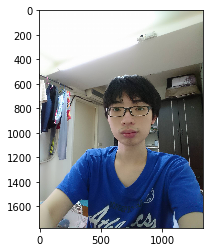

In [152]:

imgs_scores = list()

for a_index, a_objs in enumerate(imgs_hist_list):
    compare_sum = 0
    print('\n比對a組的 第{}張圖片'.format(b_match_a[a_index]))
    print('b組：')
    
    #圖片
    img_score = 0
    
    # 在種類b_class_key的A組某個圖跟B組圖比較
    all_class_high_scores = list()
    
    for b_class_key in b_obj_indexs.keys():
        print('先拿A組某地{}張圖片跟b組，先比物件{}的直方圖'.format(b_match_a[a_index], b_class_key))
        a_obj_index = a_obj_indexs[b_match_a[a_index]][b_class_key]
        b_obj_index = b_obj_indexs[b_class_key]
        print('a_obj_index, ', a_obj_index)
        print('b_obj_index, ', b_obj_index)
        a_filter_class_hists = [a_objs[inx] for inx in a_obj_index]
        b_filter_class_hists = [b_obj_hist[inx] for inx in b_obj_index] 
        

        class_high_scores = list()
        # N類別的a圖的所有物件 
        for a_h in a_filter_class_hists:
            
            ab_compare_scores = list()
            
            # N類別的a圖的單個物件 跟 N類別的b圖的所有物件 做比較
            for b_h in b_filter_class_hists:
            
                # 計算彼此直方圖相似度，並加入串列中。
                ab_compare_score = cv2.compareHist(a_h, b_h, cv2.HISTCMP_CORREL)
                ab_compare_scores.append(ab_compare_score)
                print('ab_compare_score =', ab_compare_score)
            # N類別a圖單個物件跟跟 N類別的b圖的所有物件，將最高的相似度添加到 class_high_scores
            class_high_scores.append(max(ab_compare_scores))
            print('max(ab_compare_scores)=', max(ab_compare_scores))
        
        # 將某一個N類別a組圖所有物件跟b圖所有物件 把所有物件最高分數取平均，獲得N類別的相似度
        N_class_high_score = sum(class_high_scores)/ len(class_high_scores) 
        print('N_class_high_score =', class_high_scores)
        
        #並將他添加到 所有類別分數串列底下
        all_class_high_scores.append(N_class_high_score)
        
    # 所以一張圖片的分數 = 一張圖片所有類別分數的平均
    img_score = sum(all_class_high_scores) / len(all_class_high_scores)
    print('img_score =', img_score)
    
    # 將該圖片的分數 添加到 所有圖片的分數
    imgs_scores.append(img_score)
print('img_scores', imgs_scores)

if not imgs_scores:
    print('沒有相符的圖片')
else:
    max_score = max(imgs_scores)
    max_index = imgs_scores.index(max_score)

    # 結果
    print('a組第{}張圖片是與b圖色彩特徵最相似的...，物件色彩特徵相似度高達{:f}%'.format(b_match_a[max_index], max_score*100))
    similar_img_name = os.path.join(PATH_TO_TEST_IMAGES_DIR, IMAGE_HEAD_NAME.format(b_match_a[max_index]))
    similar_img = cv2.imread(similar_img_name)

    plt.figure()
    plt.imshow(cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB))


# 紀錄... dog60.jpg
# dog6.jpg, dog13.jpg, dog28.jpg, dog69.jpg, dog56.jpg
# 需要修圖軟體(PS, Gimp)把它修正解析度，將向素拉等比例拉大到寬至少有460pxl 
# dog75.jpg 和dog76.jpg

